In [1]:
from hnn_core import simulate_dipole, calcium_model, MPIBackend, law_2021_model
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import add_supra_beta_drives, rescale_pyr_morph, add_law_beta_drives
sns.set()

In [2]:
net_orig = law_2021_model()


In [3]:
%%capture
scaling_factors = [1, .5, .2]
props = ['L', 'diam', 'Ra', 'cm']
pyr_cells = ['L2_pyramidal', 'L5_pyramidal']

net_list = list()
dpl_list = list()
for scaling_factor in scaling_factors:
    net = net_orig.copy()
    add_law_beta_drives(net, beta_start=200, strength=scaling_factor)
    for prop in props:        
        if prop == 'cm':
            scaling_factor = 1/scaling_factor
        rescale_pyr_morph(net=net, cell_types=pyr_cells, compartment_prop=prop, scaling_factor=scaling_factor)
    with MPIBackend(n_procs=8):
        dpl = simulate_dipole(net, tstop=500)

    net_list.append(net.copy())
    dpl_list.append(dpl[0].copy())


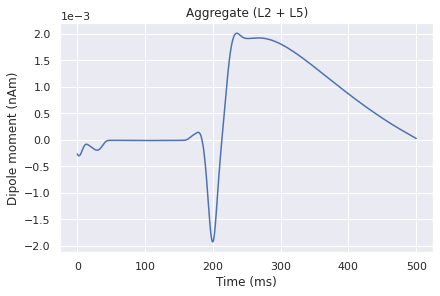

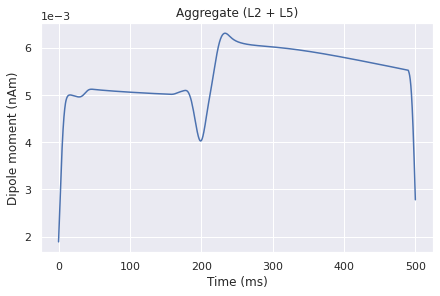

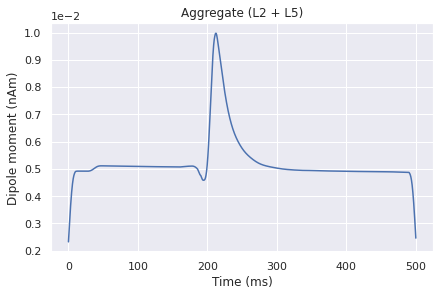

In [7]:
for idx in range(3):
    plot_dipole(dpl_list[idx].copy().smooth(20))

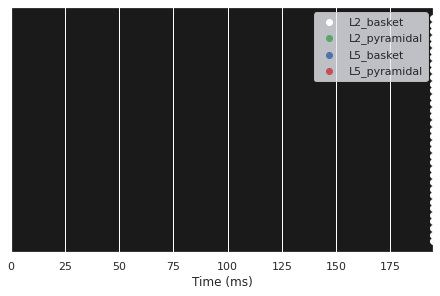

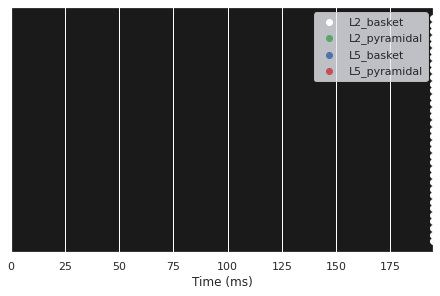

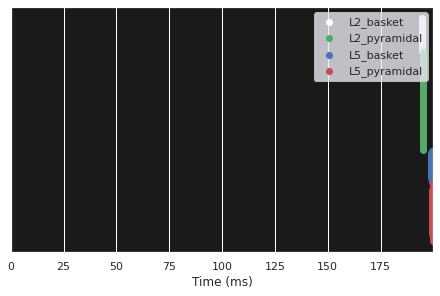

In [5]:
for net in net_list:
    net.cell_response.plot_spikes_raster()
